<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/MC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [14]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    return acorr[0 : len(acorr) // 2]

class Particle():
  def __init__(self,position):
    self.position = np.array(position)

class System():
  def __init__(self,N,L,sigma):
    self.N = N
    self.L = L
    self.sigma = sigma

    self.particles = []
    for i in range(self.N):
      position = np.random.uniform(-self.L/2,self.L/2,3)
      self.particles.append(Particle(position))

    # Check and resolve overlaps
    for i in range(self.N):
        overlap = True
        while overlap:
            overlap = False
            for j in range(i):  # Only check previous particles
                distance = self.minimum_image_distance(self.particles[i].position, self.particles[j].position)
                if distance < self.sigma:  # Overlap detected
                    self.particles[i].position = np.random.uniform(0, self.L, 3)
                    overlap = True
                    break  # Restart check for this particle

    self.energy = self.calculate_energy()

  def minimum_image_distance(self,pos1,pos2):
    diff_vector = pos1 - pos2
    diff_vector = (diff_vector+(self.L/2))%self.L-(self.L/2)
    return np.linalg.norm(diff_vector)

  def calculate_energy(self):
    energy = 0
    for i in range(len(self.particles)):
      for j in range(len(self.particles)):
        if i < j:
          distance = self.minimum_image_distance(self.particles[i].position,self.particles[j].position)
          epsilon = 1.0
          energy += 4*epsilon*((self.sigma/distance)**12 - (self.sigma/distance)**6)
    self.energy = energy
    return energy

  def plot_positions(self):
    positions = [self.particles[i].position for i in range(self.N)]
    positions = np.array(positions)
    x,y,z = positions.T

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x,y,z)
    lim = self.L/2
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    return ax

class Dynamics():
  def __init__(self,N,L,sigma,nsteps,temperature):
    self.system = System(N,L,sigma)
    self.nsteps = nsteps
    self.T = temperature
    self.energies = []
    self.per_particle_energies = []

  def run_dynamics(self):
    self.accepted = 0
    self.rejected = 0
    for i in range(self.nsteps):
      new_system = copy.deepcopy(self.system)
      rand_particle_index = np.random.randint(0,new_system.N)
      random_movement = np.random.uniform(-new_system.sigma,new_system.sigma)
      random_direction = np.random.randint(3) # 0=x, 1=y, 2=z
      new_system.particles[rand_particle_index].position[random_direction] = new_system.particles[rand_particle_index].position[random_direction] + random_movement
      if np.abs(new_system.particles[rand_particle_index].position[random_direction]) >= new_system.L/2:
        new_system.particles[rand_particle_index].position[random_direction] = (new_system.particles[rand_particle_index].position[random_direction]+(new_system.L/2))%new_system.L-(new_system.L/2)


      new_energy = new_system.calculate_energy()
      delta_E = new_energy - self.system.energy
      if delta_E < 0:
        self.system = new_system
        self.energies.append(new_energy)
        self.accepted += 1
      elif delta_E >= 0:
        boltzmann_factor = np.exp(-delta_E/self.T)
        rand = np.random.random()
        if rand <= boltzmann_factor:
          self.system = new_system
          self.energies.append(new_energy)
          self.accepted += 1
        elif rand > boltzmann_factor:
          self.energies.append(self.system.energy)
          self.rejected += 1
    self.per_particle_energies = np.array(self.energies)/self.system.N

  def plot_energy(self):
    fig = plt.figure(figsize = (15,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(self.energies)
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel('System Energy ($\epsilon$)')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(self.per_particle_energies)
    ax2.set_xlabel('Simulation Step')
    ax2.set_ylabel('Per-Particle Energy ($\epsilon$)')



# Autocorrelation Testing

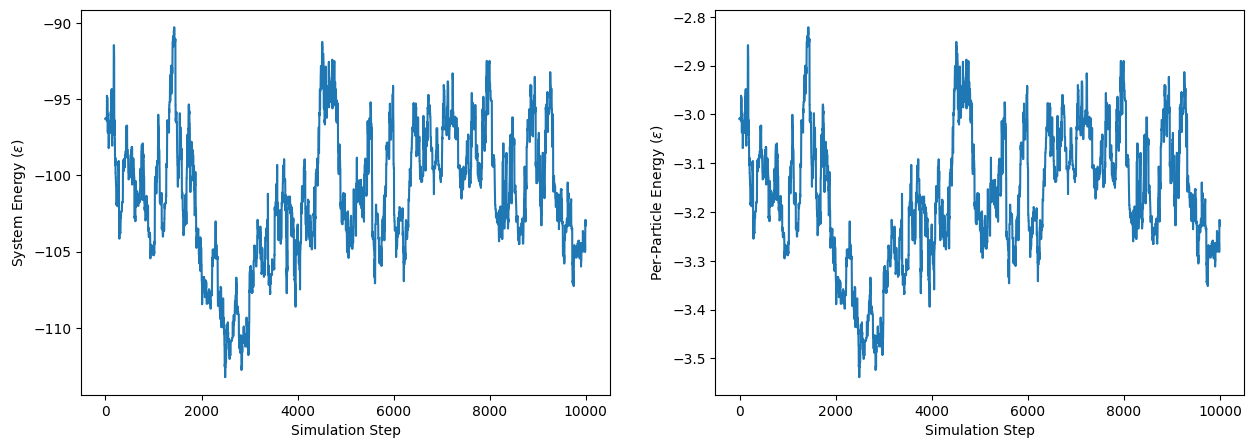

In [15]:
sim = Dynamics(32,4,1,50000,1)
sim.run_dynamics()
sim.plot_energy()

In [20]:
mean = np.mean(sim.per_particle_energies)
stdev = np.std(sim.per_particle_energies)

print(f'{mean} +/- {stdev}')

-3.1647289121632958 +/- 0.13381973223621763


Decorrelation "time" = 485 steps


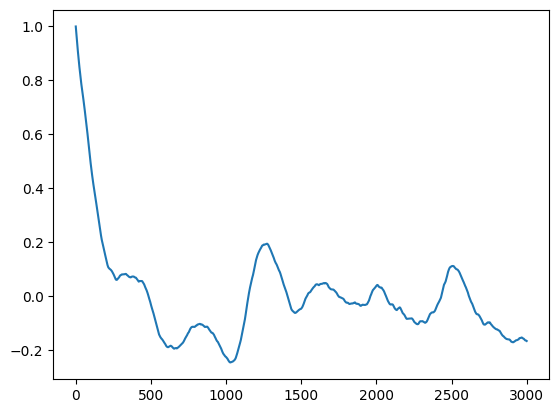

In [27]:
acf = autocorr1D(sim.per_particle_energies[4000:])
plt.plot(acf)
print(f'Decorrelation "time" = {np.where(acf<0)[0][0]} steps')

# 3. Characterize Performance

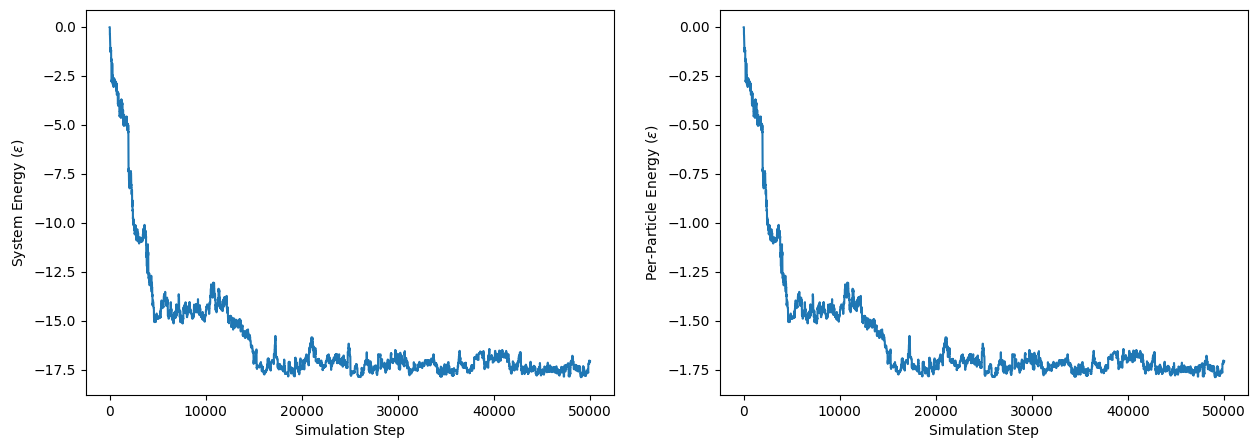

In [ ]:
# System with particle density (N/V) of 0.01 sigma^-3
# equilibrate in about 15,000 steps at T = 0.1

temp_test = Dynamics(10,10,1,50000,0.1)
temp_test.run_dynamics()
temp_test.plot_energy()

51.85757350921631


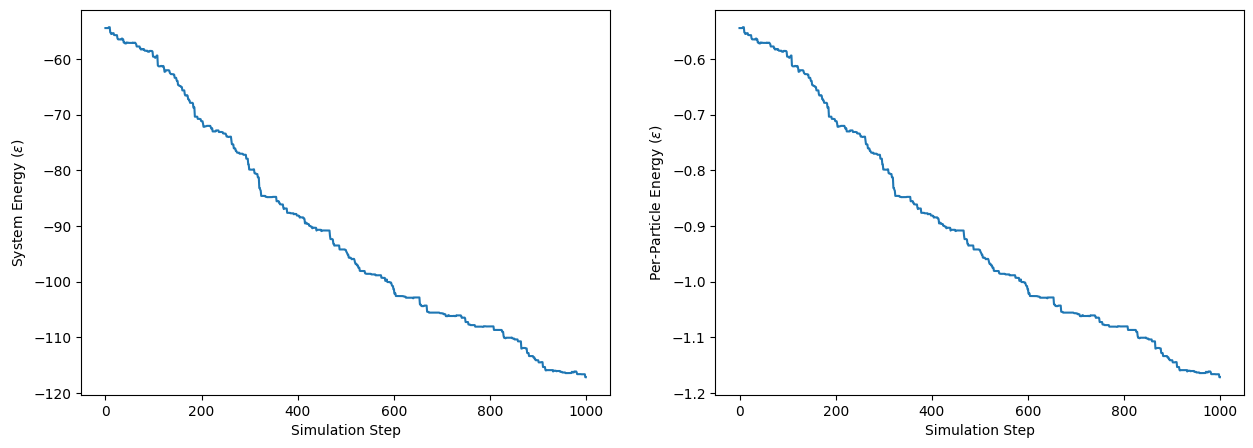

In [ ]:
# I can't feasibly test higher densities with this system size.
# A system of 100 particles, which only achieves N/V = 0.1 sigma^-3,
# takes almost 1 minute to run for 1000 particles.

import time
t0 = time.time()
time_test = Dynamics(100,10,1,1000,0.1)
time_test.run_dynamics()
time_test.plot_energy()
t1 = time.time()
print(t1-t0)

265.1411497592926


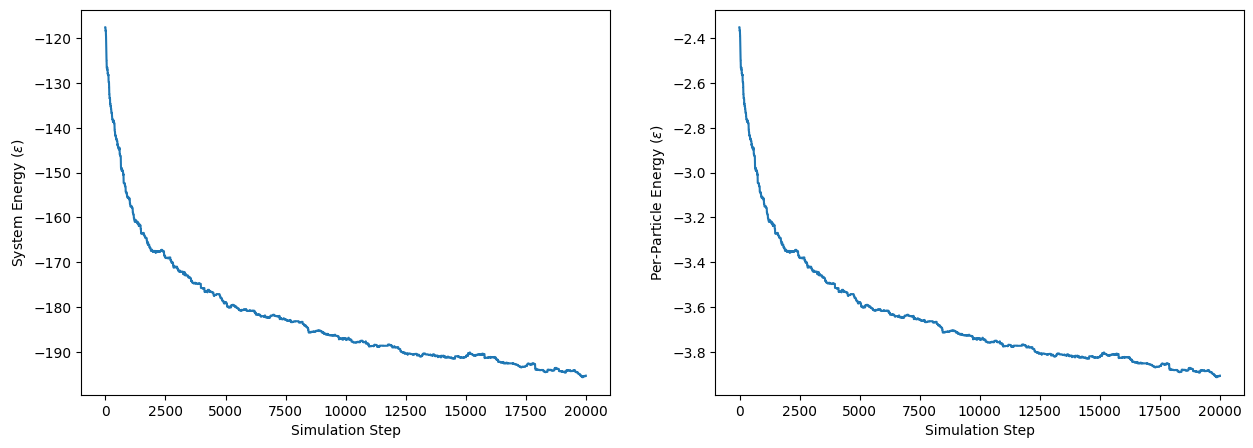

In [ ]:
# This is right near the limit of what is feasible.
# A system with N/V = 50/125 = 0.4 nears equilibration
# after about 20,000 steps. It take around 4m 30s to run.

t0 = time.time()
dens_test = Dynamics(50,5,1,20000,0.1)
dens_test.run_dynamics()
dens_test.plot_energy()
t1 = time.time()
print(t1-t0)

In [ ]:
# Now that I know what the particle density limits are, it's interesting to
# see how systems of different size but similar N/V value compare to one another.

size_test1 = Dynamics(26,4,1,20000,0.1) # N/V = 0.40625 sigma^-3
size_test1.run_dynamics()

size_test2 = Dynamics(11,3,1,20000,0.1) # N/V = 0.40741 sigma^-3
size_test2.run_dynamics()

size_test3 = Dynamics(3,2,1,20000,0.1) # N/V = 0.375 sigma^3
size_test3.run_dynamics()

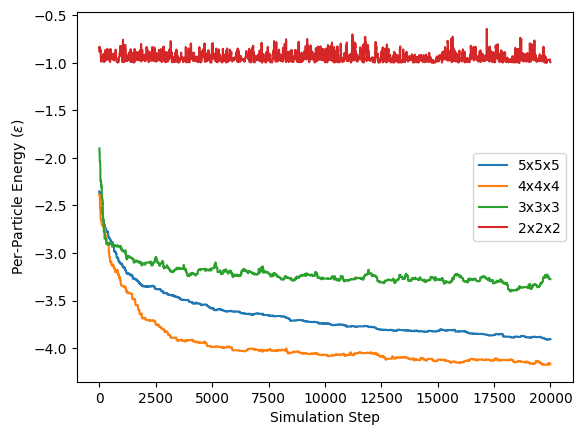

In [ ]:
# The 4x4x4 system strikes the best balance between physical realism
# and computational efficiency.

plt.plot(dens_test.per_particle_energies, label='5x5x5')
plt.plot(size_test1.per_particle_energies, label='4x4x4')
plt.plot(size_test2.per_particle_energies, label='3x3x3')
plt.plot(size_test3.per_particle_energies, label='2x2x2')
plt.xlabel('Simulation Step')
plt.ylabel('Per-Particle Energy ($\epsilon$)')
plt.legend()

# 4. Compare to ideal gas

<Axes3D: >

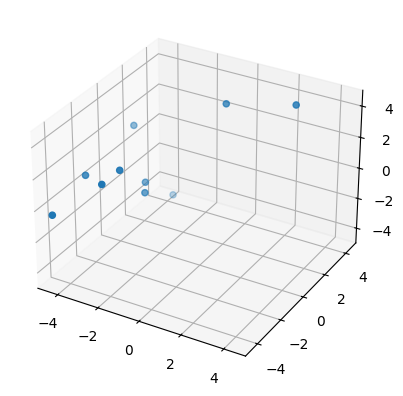

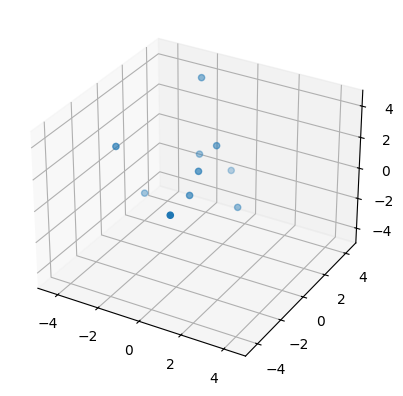

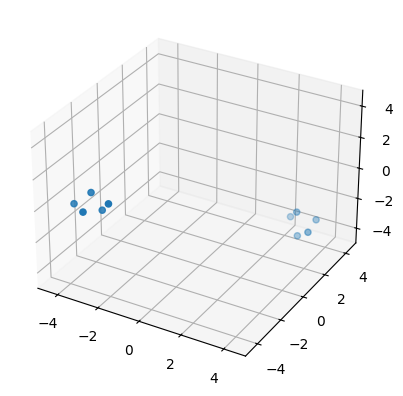

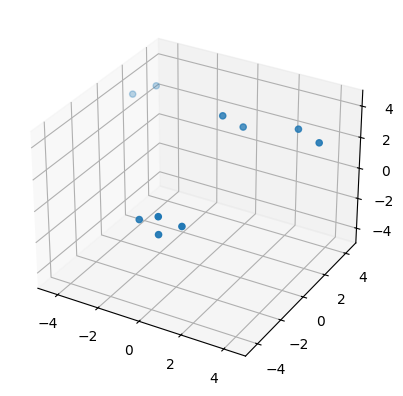

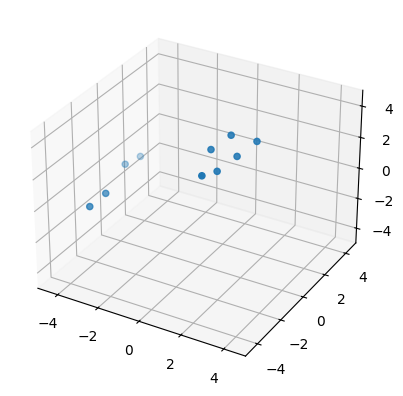

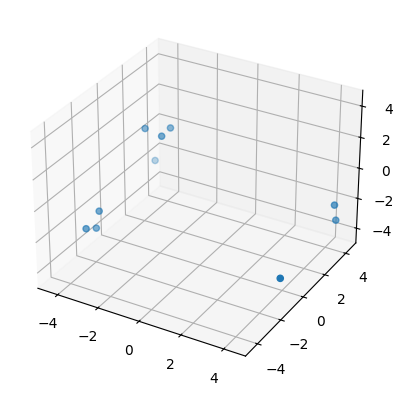

In [ ]:
# Show how the structure of the model varies with state

# variance with temperature
temp_0 = Dynamics(10,10,1,10000,10)
temp_0.run_dynamics()
temp_0.system.plot_positions()

temp_1 = Dynamics(10,10,1,10000,1)
temp_1.run_dynamics()
temp_1.system.plot_positions()

temp_2 = Dynamics(10,10,1,10000,0.1)
temp_2.run_dynamics()
temp_2.system.plot_positions()

temp_3 = Dynamics(10,10,1,10000,0.01)
temp_3.run_dynamics()
temp_3.system.plot_positions()

temp_4 = Dynamics(10,10,1,10000,0.001)
temp_4.run_dynamics()
temp_4.system.plot_positions()

temp_5 = Dynamics(10,10,1,10000,0.0001)
temp_5.run_dynamics()
temp_5.system.plot_positions()

# You can start to see the particles clumping together at lower temperatures.
# For an ideal gas, where the particles do not interact with one-another,
# there would be no reason for clumping to occur. Rather, each particle's
# average kinetic energy would simply decrease, resulting in the molecules
# moving more slowly and a smaller pressure being applied to the walls
# of the container.

<Axes3D: >

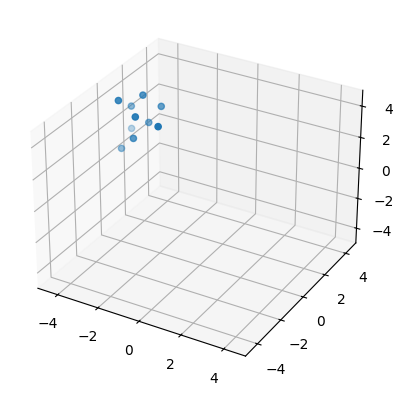

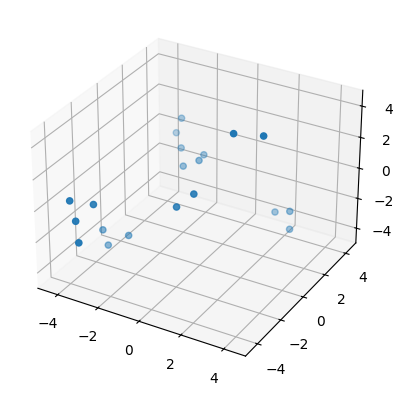

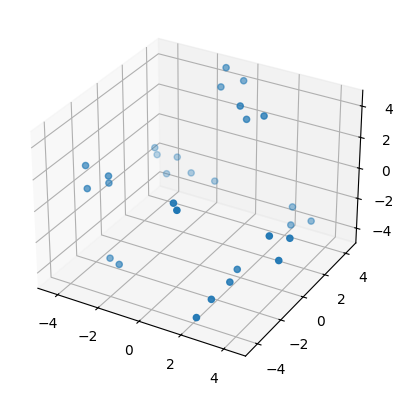

In [ ]:
# Structure varying with N

N_0 = Dynamics(10,10,1,10000,0.1)
N_0.run_dynamics()
N_0.system.plot_positions()

N_1 = Dynamics(20,10,1,10000,0.1)
N_1.run_dynamics()
N_1.system.plot_positions()

N_2 = Dynamics(30,10,1,10000,0.1)
N_2.run_dynamics()
N_2.system.plot_positions()

# It seems that with smaller N, it is likely for all the particles to cluster together.
# The larger N becomes, the more likely to see multiple clusters forming, probably
# due to an increased probability of a particle moving from being close to one cluster
# to being close to another cluster. Again, non-interacting particles should not cluster
# at all, but rather be fairly eenly distributed in space.

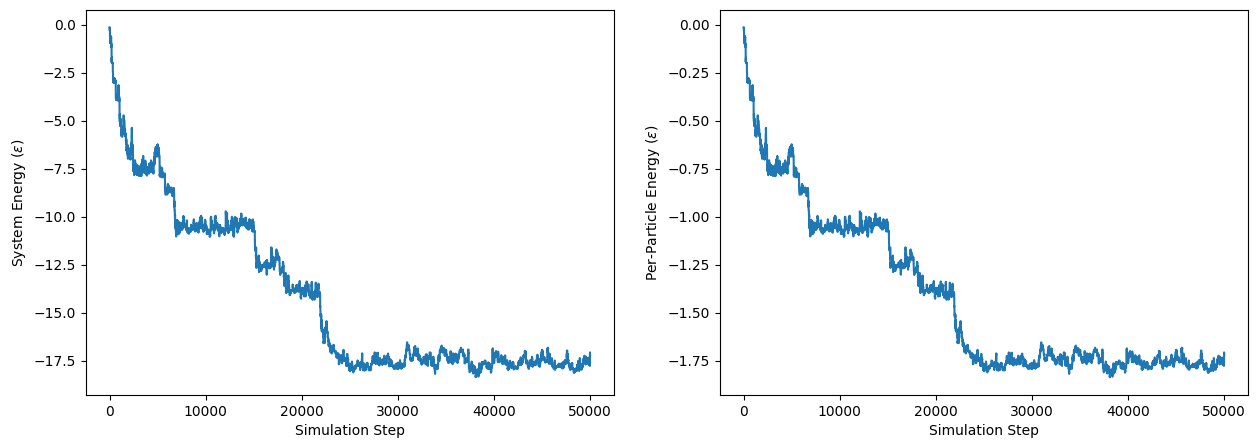

In [ ]:
# Show whether the heat capacity of this system is different from that of an ideal gas (C_v = 3/2*kB)

calc_hc = Dynamics(10,10,1,50000,0.1)
calc_hc.run_dynamics()
calc_hc.plot_energy()

In [ ]:
eq_potential = np.array(calc_hc.energies[25000:])
eq_pot_square = eq_potential**2
k_B = 1.380649E-23 # J/K

reduced_heat_capacity = (np.mean(eq_pot_square) - (np.mean(eq_potential))**2)/(0.1**2)
heat_capacity = reduced_heat_capacity*k_B
ratio = heat_capacity/(1.5*k_B)
print('Calculated heat capacity:', heat_capacity)
print('Ratio of model HC to ideal gas HC:', ratio)


Calculated heat capacity: 1.25390093619727e-22
Ratio of model HC to ideal gas HC: 6.054645007274453


Calculated heat capacity: 8.33567990918759e-24
Ratio of model HC to ideal gas HC: 0.40250055875594687


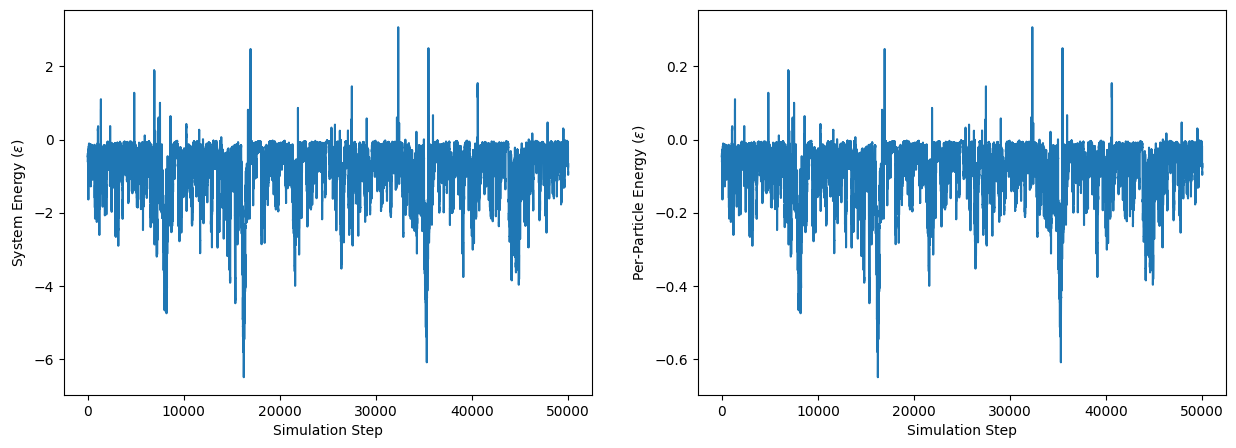

In [ ]:
calc_hc_hightemp = Dynamics(10,10,1,50000,1)
calc_hc_hightemp.run_dynamics()
calc_hc_hightemp.plot_energy()

eq_potential = np.array(calc_hc_hightemp.energies[25000:])
eq_pot_square = eq_potential**2
k_B = 1.380649E-23 # J/K

reduced_heat_capacity = (np.mean(eq_pot_square) - (np.mean(eq_potential))**2)/(1**2)
heat_capacity = reduced_heat_capacity*k_B
ratio = heat_capacity/(1.5*k_B)
print('Calculated heat capacity:', heat_capacity)
print('Ratio of model HC to ideal gas HC:', ratio)

Calculated heat capacity: 5.81850679930041e-21
Ratio of model HC to ideal gas HC: 280.9551546314045


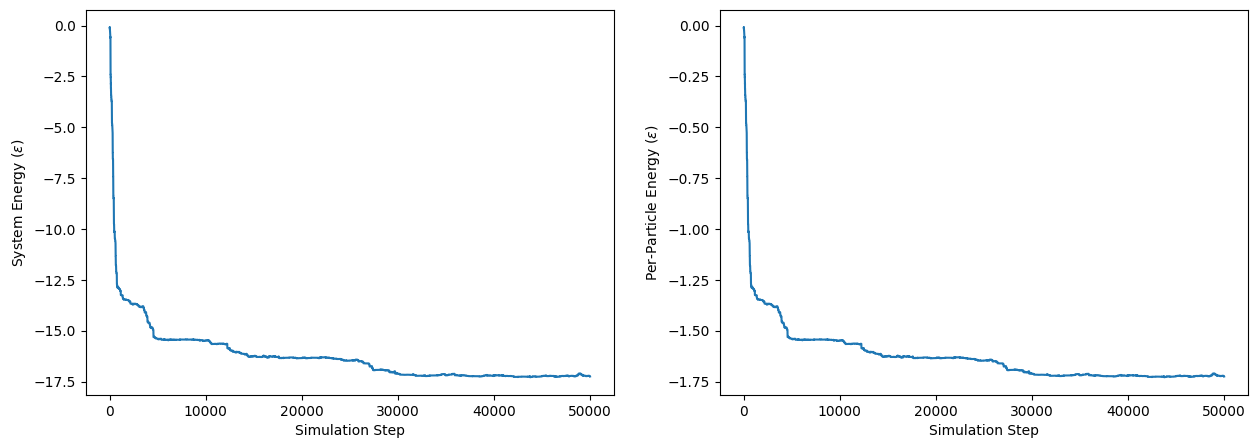

In [ ]:
calc_hc_lowtemp = Dynamics(10,10,1,50000,0.01)
calc_hc_lowtemp.run_dynamics()
calc_hc_lowtemp.plot_energy()

eq_potential = np.array(calc_hc_lowtemp.energies[25000:])
eq_pot_square = eq_potential**2
k_B = 1.380649E-23 # J/K

reduced_heat_capacity = (np.mean(eq_pot_square) - (np.mean(eq_potential))**2)/(0.01**2)
heat_capacity = reduced_heat_capacity*k_B
ratio = heat_capacity/(1.5*k_B)
print('Calculated heat capacity:', heat_capacity)
print('Ratio of model HC to ideal gas HC:', ratio)

The simulations above show that the heat capacity of this system relies very heavily on state, as compared to the ideal gas which should not depend on state at all. At high temperatures, the heat capacity is lower and much closer to the value predicted by the ideal gas approximation. At low temperature, however, when intermolecular interactions become more dominant than entropy, the ideal gas approximation fails. The heat capacity at a reduced temperature of 0.01 epsilon was nearly 300 times greater than the value predicted by the ideal gas approximation.

# 5. Summary

This system of mono-atomic particles interacting with the Lennard-Jones potential does an excellent job of modeling the equilibration of a gas based on its temperature and density. It goes beyond the ideal gas approximation by modeling the configurations taken on by interacting particles, and correcting figures such as the heat capacity in states where interaction potentials dominate entropy. Thanks to this, we observe phase transitions where molecules begin clustering together.

The system still has many limitations, of course. Our model assumes all particles are of uniform shape and size, monoatomic, and uncharged. I imagine accounting for charges would be as simple as incorporating a coulombic term into the calculation of the potential. Incorporating multiple different particle sizes, however, would be trickier, however, as it would require the interaction potential to depend not only on one sigma value, but on (I assume) the average between the sigma values of the two interacting particles. Finally, including bonded interactions for molecules would require a complete overhaul of both the potentials being used as well as the trial move scheme.

I learned a lot from working on this project, including very fundamental skills like object-oriented programming and utilizing the power of numpy arrays. Two topics specific to molecular simulation that stood out to me were the implementation of periodic boundary conditions and the used of reduced units.

In the past, I've always thought of periodic boundary conditions simply as a trick that's used to avoid unphysical scenarios. While this is true, in some respect, when researching how to implement PBC, I happened across an amazing blog post that described PBC as its own perfectly mathematically consistent coordinate system. (https://medium.com/@tom-mohr/periodic-boundaries-2883becbdd98). To utilize this coordinate system there are unique operators that have to be used in place of typical vector addition. Furthermore, there are applications beyond simulations in periodic systems like music and color theory. It reminded me a lot of when I first learned about spherical and hyperbolic geometry, and how that changes some of the fundamental rules of what is and isn't possible with math. It was very cool to see.

The reduced units are also very fascinating to me. I can completely see how and why they're useful, but I can also tell that I need quite a bit more practice with using them. I assume we'll continue to use them for the rest of this semester, so I look forward to improving!